CU Boulder MSDS DTSA 5798<br>
Supervised Text Classification for Marketing Analytics<br>

## Topic Detection using k-Train

Contextual advertising is an important aspect of digital advertising. This allows advertisers to advertise on web pages that match specific types of content.

This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from [HuffpPost](https://www.huffpost.com) and [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset). Each news headline has a corresponding category, totaling 41 categories.

The task is to detect the categories "WELLNESS" and "HEALTHY LIVING", which together account for about 12.2% of the total dataset.


## Imports and Setting

In [ ]:
import os
import time
import random
import pandas as pd
import numpy as np
!pip install -q tf-keras
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))
os.environ['TF_USE_LEGACY_KERAS'] = '1'
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))

try:
  import ktrain
except:
  !pip install -q ktrain
  import ktrain

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.backend import clear_session
import gc
import warnings
warnings.filterwarnings("ignore")

SEED = 2004
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use('bmh')
plt.rcParams['font.size'] = 10

TF_USE_LEGACY_KERAS: None
TF_USE_LEGACY_KERAS: 1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 58.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
      print("Found GPU:", gpu)
else:
  print("GPU not found.")

Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Inspect Data

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/dtsa5798_supervised_text_classification"
DATA_DIR = "%s/data" % ROOT_DIR
MODEL_DIR = "%s/model" % ROOT_DIR
PRED_DIR = "%s/predictor" % ROOT_DIR

In [ ]:
reviews = pd.read_json('%s/news_category_trainingdata.json' % DATA_DIR)
reviews.shape

(200853, 6)

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


In [ ]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
print('number of categories: ', reviews.category.nunique())
reviews.category.unique()

number of categories:  41


array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [ ]:
reviews[reviews['category']=='HEALTHY LIVING'].sample(3)

,category,headline,authors,link,short_description,date
21116,HEALTHY LIVING,Obesity: An Individualized Approach Doubles Th...,"Mayo Clinic Women's Health, ContributorOptimiz...",https://www.huffingtonpost.com/entry/obesity-a...,Many people think if they just stick to a diet...,2017-07-19
120926,HEALTHY LIVING,Because I Can,"Judith Greenberg, Ph.D., ContributorGallatin S...",https://www.huffingtonpost.com/entry/just-do-i...,,2014-06-05
124431,HEALTHY LIVING,Eating Is Not a Hobby,"William Anderson, MA, LMHC, ContributorLicense...",https://www.huffingtonpost.com/entry/eating-is...,,2014-04-24


In [ ]:
reviews[reviews['category']=='WELLNESS'].sample(3)

,category,headline,authors,link,short_description,date
126018,WELLNESS,Engineer Involved In Fatal Metro-North Train D...,,https://www.huffingtonpost.com/entry/sleep-apn...,Symptoms of sleep apnea are often not very spe...,2014-04-07
183723,WELLNESS,Counting Calories Is Not Enough,"Timi Gustafson, R.D., Contributor\nRegistered ...",https://www.huffingtonpost.com/entry/counting-...,Nutrition experts have long known that one of ...,2012-07-30
187613,WELLNESS,Getting a Massage: Dos and Don'ts,"Leslie Irish Evans, Contributor\nAuthor, blogg...",https://www.huffingtonpost.com/entry/massage-t...,As a licensed massage practitioner (and an ard...,2012-06-18


In [ ]:
cat_counts = reviews.category.value_counts()
cat_perc = (cat_counts / cat_counts.sum()) * 100
print(f'category counts: \n{cat_counts}\n')
print(f'category percentages: \n{cat_perc}')

category counts: 
category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION    

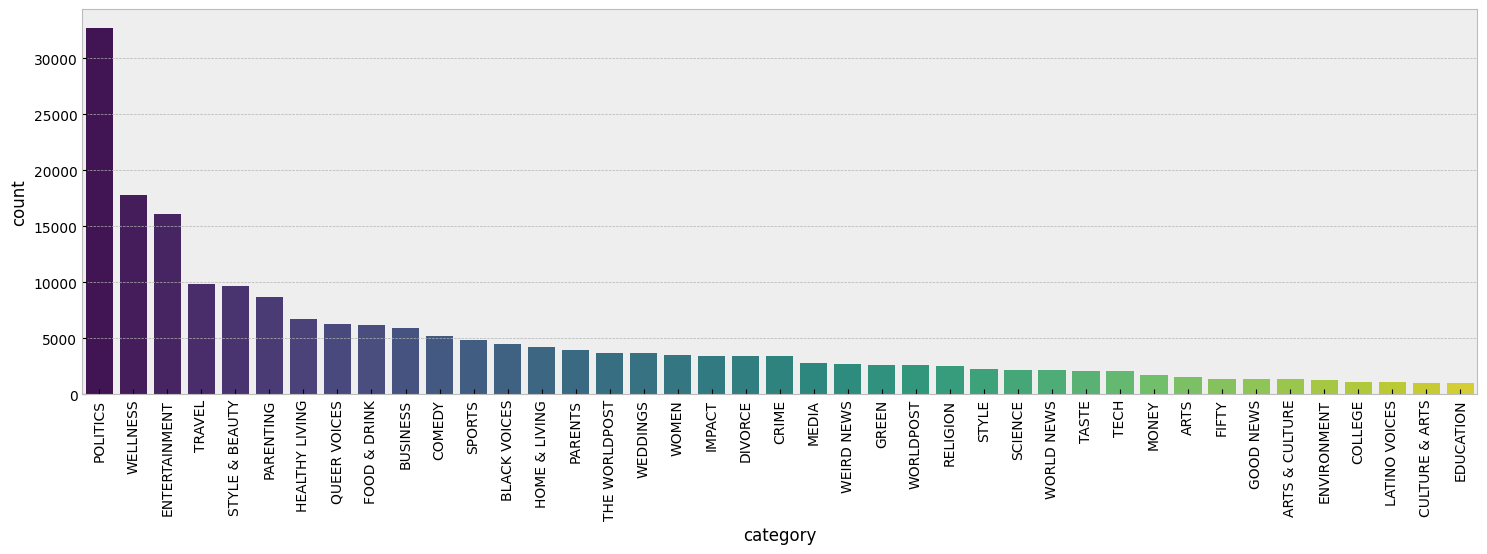

In [ ]:
cat_order = cat_counts.index
colors = sns.color_palette("viridis", len(cat_order))
plt.figure(figsize=(18,5))
sns.countplot(x='category', data=reviews, order=cat_order, palette=colors)
plt.tick_params(axis='x', rotation=90)

## Process Data

In [ ]:
# set 'HEALTHY LIVING' and 'WELLNESS' as target 1
reviews['target'] = np.where((reviews['category'] == 'HEALTHY LIVING') |
                             (reviews['category'] == 'WELLNESS'), 1, 0)
num_tar = len(reviews.query('target==1'))
tot_tar = len(reviews)
print(f'{reviews.target.value_counts()}\n')
print(f'target percentage: {(num_tar/tot_tar) * 100:.3f} %')

target
0    176332
1     24521
Name: count, dtype: int64

target percentage: 12.208 %


In [ ]:
reviews.target.describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [ ]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

#### Reduced Reviews

randomly sample 5% from the dataset

In [ ]:
reviews_reduced = reviews.sample(frac=0.05, random_state=SEED)
print(f'Reduced revies includes {reviews_reduced.shape[0]} data.')

num_tar = (reviews_reduced['target'] == 1).sum()
num_nontar = (reviews_reduced['target'] == 0).sum()
print(f'Reduced reviews data includes {num_tar} target.')
print(f'Reduced revies data includes {num_nontar} non-target.')

Reduced revies includes 10043 data.
Reduced reviews data includes 1245 target.
Reduced revies data includes 8798 non-target.


#### Balanced Reviews

randomly sample 2000 samples from each category

In [ ]:
num_sample = 2000
target = reviews[reviews['target']==1].sample(num_sample)
non_target = reviews[reviews['target']==0].sample(num_sample)
balanced_reviews = pd.concat([target, non_target])
# balanced_reviews.describe()

In [ ]:
balanced_reviews.sample(3)

,category,headline,authors,link,short_description,date,target,combined_text
93879,HEALTHY LIVING,Why We Ignore Good Advice (And How To Stop),"Tyler Tervooren, ContributorFounder, Riskology",https://www.huffingtonpost.com/entry/core-valu...,If you've ever ignored good advice and later r...,2015-04-11,1,Why We Ignore Good Advice (And How To Stop) If...
7485,BLACK VOICES,A Pam Grier Biopic May Be Coming To The Big Sc...,Taryn Finley,https://www.huffingtonpost.com/entry/pam-grier...,Jay Pharoah is set to portray Richard Pryor in...,2018-01-17,0,A Pam Grier Biopic May Be Coming To The Big Sc...
154320,WELLNESS,Happiness And Money: Why You Should Be Suspici...,,https://www.huffingtonpost.com/entry/why-buyin...,This is cause for concern. People have already...,2013-06-09,1,Happiness And Money: Why You Should Be Suspici...


## Models

In [ ]:
def prepare_and_lr_find(model_name, X_train, y_train, X_val, y_val, isTransformer=False, batch_size=16, max_epochs=6):
    if isTransformer:
        preproc = ktrain.text.Transformer(model_name, maxlen=512, class_names=['negative', 'positive'])
        train = preproc.preprocess_train(X_train, y_train)
        val = preproc.preprocess_test(X_val, y_val)
        model = preproc.get_classifier()

    else:
        if model_name in ['fasttext', 'bigru']:
            preproc_name = 'standard'
        else:
            preproc_name = model_name

        train, val, preproc = ktrain.text.texts_from_array(
            x_train=X_train, y_train=y_train,
            x_test=X_val, y_test=y_val,
            class_names=['negative', 'positive'],
            preprocess_mode=preproc_name,
            maxlen=512)
        model = ktrain.text.text_classifier(model_name, train, preproc, multilabel=False)

    learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=batch_size)
    learner.lr_find(max_epochs=max_epochs)
    return learner, train, val, preproc

def train_and_save_predictor(model_name, learner, train, val, preproc, lr, class_weight_dict):
    history = learner.autofit(
        lr,
        checkpoint_folder=MODEL_DIR,
        class_weight=class_weight_dict,
        epochs=10,
        early_stopping=3,
        reduce_on_plateau=2,
        reduce_factor=1.5
    )
    predictor = ktrain.get_predictor(learner.model, preproc=preproc)
    predictor.save(f"{MODEL_DIR}/predictor_{model_name}")
    validation = learner.validate(val_data=val, print_report=True)
    return history, validation

def plot_histories(histories, key='loss'):
    plt.figure(figsize=(9, 6))
    for name, history in histories.items():
        val = plt.plot(history.epoch, history.history['val_' + key], '--', label=f'{name} Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(), label=f'{name} Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.title())
    plt.legend()
    plt.title(f'Training and Validation {key.title()} by Model')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def print_results(results):
    plt.rcParams['font.size'] = 14
    for model_name, matrix in results.items():
        print(f"Model: {model_name}")
        print(matrix)
        row_sums = matrix.sum(axis=1)
        norm_matrix = matrix / row_sums[:, np.newaxis]
        perc_matrix = norm_matrix * 100
        plt.figure(figsize=(5, 3))
        sns.heatmap(perc_matrix, annot=True, fmt=".2f", cmap='Blues')
        plt.grid(False)
        plt.title(f'Confusion Matrix for {model_name}', fontsize=12)
        plt.show()
        print()

def get_model_predictions(model_name, X_val):
    predictor = ktrain.load_predictor(f"{MODEL_DIR}/predictor_{model_name}")
    y_pred_probs = [predictor.predict(text, return_proba=True)[1] for text in X_val]
    return np.array(y_pred_probs)

def plot_roc_curves(model_names, y_preds, y_true):
    plt.figure(figsize=(8, 6))
    for model_name, y_pred in zip(model_names, y_preds):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name}, auc = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


### Reduced Reviews

randomly sample 5% from the dataset

set class_weight

use `ktrain.text.Transformer`, `get_classifier`

compare models 'distilbert-base-uncased','bert-base-uncased', 'roberta-base'

In [ ]:
texts = reviews_reduced['combined_text'].tolist()
labels = reviews_reduced['target'].tolist()
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=SEED)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

{0: 0.5698680663923961, 1: 4.078172588832487}


Training and evaluating model: distilbert-base-uncased
preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 56
	99percentile : 67


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 55
	99percentile : 65


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
502/502 [==============================] - 128s 213ms/step - loss: 0.4601 - accuracy: 0.8658
Epoch 2/6
502/502 [==============================] - 109s 216ms/step - loss: 0.2004 - accuracy: 0.9221
Epoch 3/6
502/502 [==============================] - 108s 215ms/step - loss: 0.2657 - accuracy: 0.9052
Epoch 4/6
502/502 [==============================] - 108s 214ms/step - loss: 0.4071 - accuracy: 0.8749
Epoch 5/6
502/502 [==============================] - 87s 172ms/step - loss: 8.1532 - accuracy: 0.8784


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


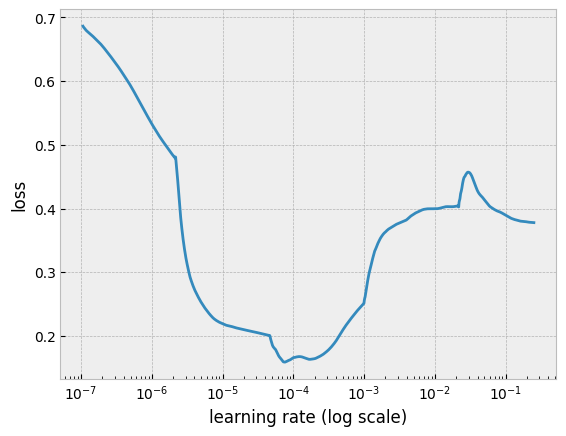

Enter learning rate: 5e-5


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/10
503/503 [==============================] - 136s 230ms/step - loss: 0.3558 - accuracy: 0.8595 - val_loss: 0.2733 - val_accuracy: 0.8900
Epoch 2/10
503/503 [==============================] - 112s 222ms/step - loss: 0.1807 - accuracy: 0.9291 - val_loss: 0.2273 - val_accuracy: 0.9084
Epoch 3/10
503/503 [==============================] - 112s 222ms/step - loss: 0.1003 - accuracy: 0.9566 - val_loss: 0.2140 - val_accuracy: 0.9338
Epoch 4/10
503/503 [==============================] - 111s 221ms/step - loss: 0.0726 - accuracy: 0.9742 - val_loss: 0.2487 - val_accuracy: 0.9258
Epoch 5/10
502/503 [============================>.] - ETA: 0s - loss: 0.0440 - accuracy: 0.9823
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 3.3333333333333335e-05 (if not early_stopping).
503/503 [==============================] - 111s 222ms/step - loss: 0.0439 - accuracy: 0.9823 - val_loss: 0.

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 56
	99percentile : 67


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 55
	99percentile : 65


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
502/502 [==============================] - 261s 428ms/step - loss: 0.4737 - accuracy: 0.7704
Epoch 2/6
502/502 [==============================] - 216s 431ms/step - loss: 0.2095 - accuracy: 0.9153
Epoch 3/6
502/502 [==============================] - 215s 429ms/step - loss: 0.2975 - accuracy: 0.8985
Epoch 4/6
502/502 [==============================] - 190s 379ms/step - loss: 0.7736 - accuracy: 0.8445


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


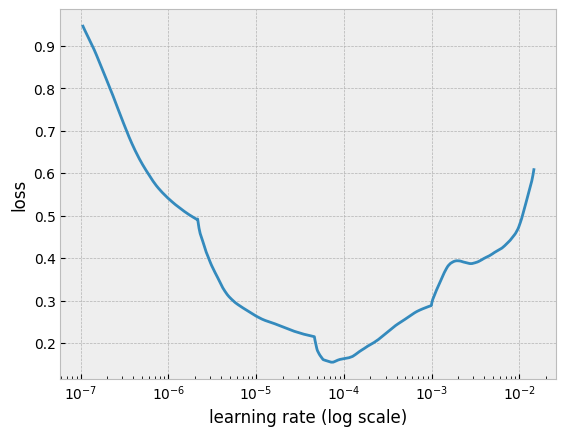

Enter learning rate: 5e-5


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/10
503/503 [==============================] - 278s 464ms/step - loss: 0.3784 - accuracy: 0.8294 - val_loss: 0.2646 - val_accuracy: 0.8950
Epoch 2/10
503/503 [==============================] - 224s 445ms/step - loss: 0.2023 - accuracy: 0.9231 - val_loss: 0.2087 - val_accuracy: 0.9273
Epoch 3/10
503/503 [==============================] - 226s 449ms/step - loss: 0.1282 - accuracy: 0.9476 - val_loss: 0.2118 - val_accuracy: 0.9238
Epoch 4/10
503/503 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9644
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 3.3333333333333335e-05 (if not early_stopping).
503/503 [==============================] - 226s 449ms/step - loss: 0.0918 - accuracy: 0.9644 - val_loss: 0.2506 - val_accuracy: 0.9233
Epoch 5/10
503/503 [==============================] - 224s 445ms/step - loss: 0.0584 - accuracy: 0.9761 - val_loss: 0.

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 56
	99percentile : 67


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 55
	99percentile : 65


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
502/502 [==============================] - 263s 430ms/step - loss: 0.4228 - accuracy: 0.8754
Epoch 2/6
502/502 [==============================] - 217s 432ms/step - loss: 0.1833 - accuracy: 0.9292
Epoch 3/6
502/502 [==============================] - 216s 431ms/step - loss: 0.3313 - accuracy: 0.8916
Epoch 4/6
502/502 [==============================] - 216s 429ms/step - loss: 0.6919 - accuracy: 0.8414
Epoch 5/6
502/502 [==============================] - 3s 5ms/step - loss: 1.8980 - accuracy: 0.8684


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


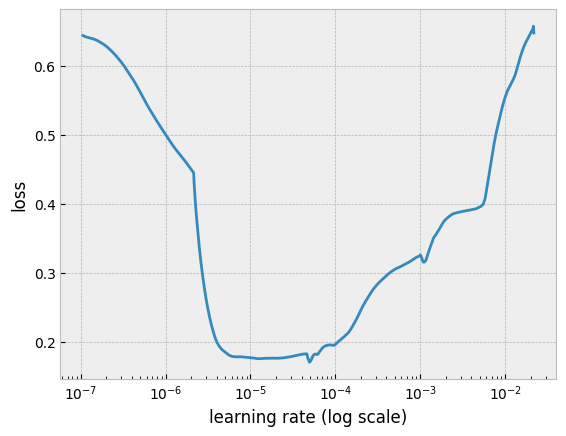

Enter learning rate: 3e-6


begin training using triangular learning rate policy with max lr of 3e-06...
Epoch 1/10
503/503 [==============================] - 281s 472ms/step - loss: 0.4065 - accuracy: 0.8418 - val_loss: 0.2933 - val_accuracy: 0.8840
Epoch 2/10
503/503 [==============================] - 225s 447ms/step - loss: 0.2107 - accuracy: 0.9132 - val_loss: 0.2040 - val_accuracy: 0.9268
Epoch 3/10
503/503 [==============================] - 228s 454ms/step - loss: 0.1718 - accuracy: 0.9294 - val_loss: 0.2075 - val_accuracy: 0.9253
Epoch 4/10
503/503 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9452
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2e-06 (if not early_stopping).
503/503 [==============================] - 224s 446ms/step - loss: 0.1415 - accuracy: 0.9452 - val_loss: 0.2200 - val_accuracy: 0.9268
Epoch 5/10
503/503 [==============================] - 225s 447ms/step - loss: 0.1197 - accuracy: 0.9520 - val_loss: 0.2015 - val_accura

In [ ]:
models = ['distilbert-base-uncased','bert-base-uncased', 'roberta-base']
histories = {}
results = {}

for model_name in models:
    print(f"Training and evaluating model: {model_name}")
    learner, train, val, preproc = prepare_and_lr_find(model_name, X_train, y_train, X_val, y_val, isTransformer=True)
    learner.lr_plot()
    best_lr = float(input("Enter learning rate: "))
    history, validation = train_and_save_predictor(model_name, learner, train, val, preproc, best_lr, class_weight_dict)
    results[model_name] = validation
    histories[model_name] = history

    del learner, train, val, preproc, history, validation
    gc.collect()
    clear_session()


### Evaluation

I attempted to train on 5% of the data randomly sampled from the original 200k reviews while maintaining the original proportion. The preprocessing here used ktrain.text.Transformer, and I trained three Transformer models: Distilbert-base, bert-base, and Roberta-base. As shown in the table below, the performance is satisfactory. However, since the original dataset is unbalanced, even though I set class weights during training, the correct classification of the target is inferior to the non-target.

| Model                   | Precision (0) | Recall (0) | F1-Score (0) | Support (0) | Precision (1) | Recall (1) | F1-Score (1) | Support (1) | Accuracy | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1-Score |
|-------------------------|---------------|------------|--------------|-------------|---------------|------------|--------------|-------------|----------|----------------------|-------------------|---------------------|------------------------|---------------------|----------------------|
| distilbert-base-uncased | 0.97          | 0.96       | 0.96         | 1749        | 0.72          | 0.79       | 0.76         | 260         | 0.93     | 0.85                 | 0.87              | 0.86                | 0.94                   | 0.93                | 0.93                 |
| bert-base-uncased       | 0.98          | 0.94       | 0.96         | 1749        | 0.67          | 0.87       | 0.76         | 260         | 0.93     | 0.82                 | 0.90              | 0.86                | 0.94                   | 0.93                | 0.93                 |
| roberta-base            | 0.98          | 0.95       | 0.97         | 1749        | 0.74          | 0.86       | 0.79         | 260         | 0.94     | 0.86                 | 0.91              | 0.88                | 0.95                   | 0.94                | 0.94                 |


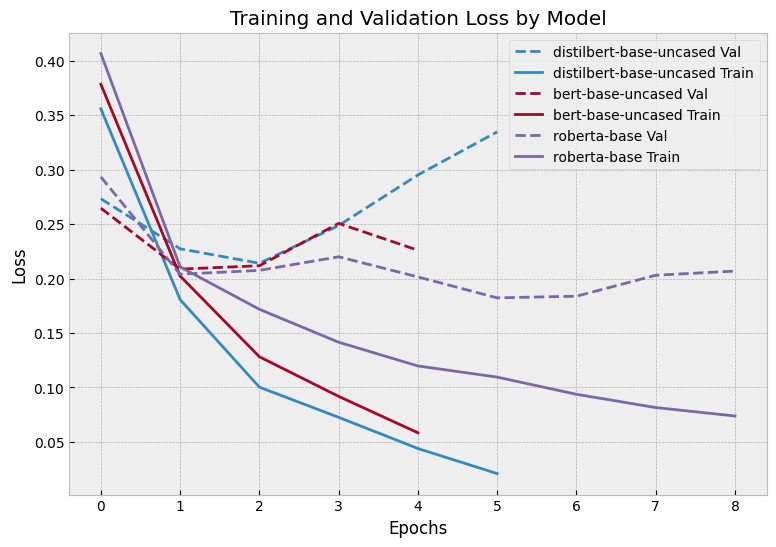

In [ ]:
plot_histories(histories, key='loss')

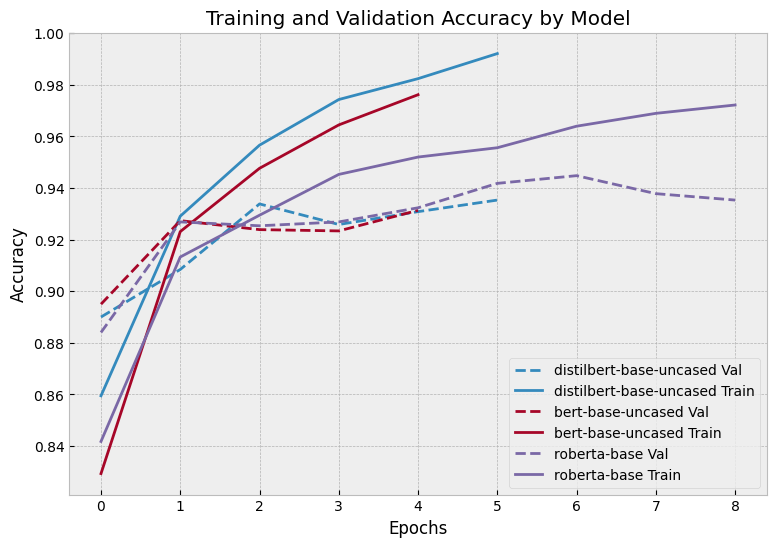

In [ ]:
plot_histories(histories, key='accuracy')

Model: distilbert-base-uncased
[[1671   78]
 [  55  205]]


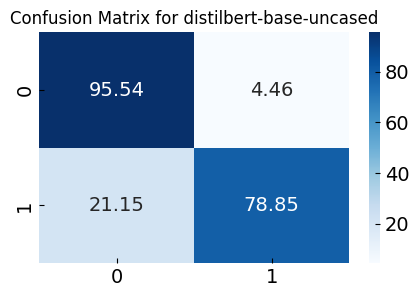


Model: bert-base-uncased
[[1637  112]
 [  34  226]]


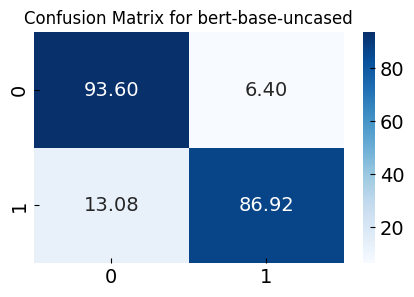


Model: roberta-base
[[1669   80]
 [  37  223]]


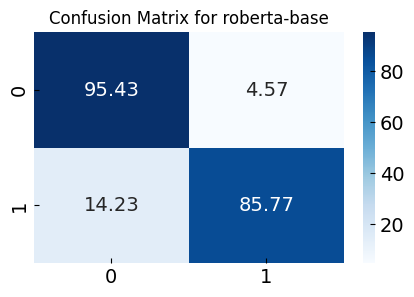

In [ ]:
print_results(results)

Here are the ROC curves and AUC values for these three models, along with their confusion matrices. Compared to Distilbert, both Bert and Roberta perform well, each with an AUC of 0.97 and more balanced correct classification for both categories.

In [ ]:
y_preds = [get_model_predictions(model_name, X_val) for model_name in models]

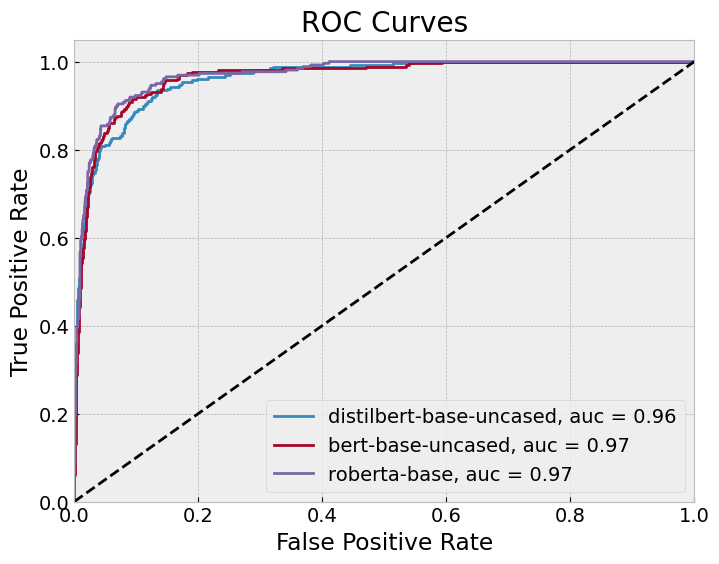

In [ ]:
plot_roc_curves(models, y_preds, y_val)

### Balanced Reviews

randomly sample 2000 samples from each category

use `ktrain.text.texts_from_array`, `ktrain.text.text_classifier`

compare models 'distilbert','bert', 'bigru'

In [ ]:
texts = balanced_reviews['combined_text'].tolist()
labels = balanced_reviews['target'].tolist()
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.1, random_state=SEED)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

{0: 0.9900990099009901, 1: 1.0101010101010102}


Training and evaluating model: distilbert


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 63


task: text classification
Is Multi-Label? False
maxlen is 512
done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/6
225/225 [==============================] - 88s 213ms/step - loss: 0.6857 - accuracy: 0.5811
Epoch 2/6
225/225 [==============================] - 48s 213ms/step - loss: 0.4262 - accuracy: 0.8394
Epoch 3/6
225/225 [==============================] - 48s 213ms/step - loss: 0.4493 - accuracy: 0.7881
Epoch 4/6
225/225 [==============================] - 48s 213ms/step - loss: 0.9119 - accuracy: 0.4867
Epoch 5/6
225/225 [==============================] - 48s 213ms/step - loss: 0.7072 - accuracy: 0.4978
Epoch 6/6
225/225 [==============================] - 48s 213ms/step - loss: 0.9733 - accuracy: 0.4917


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


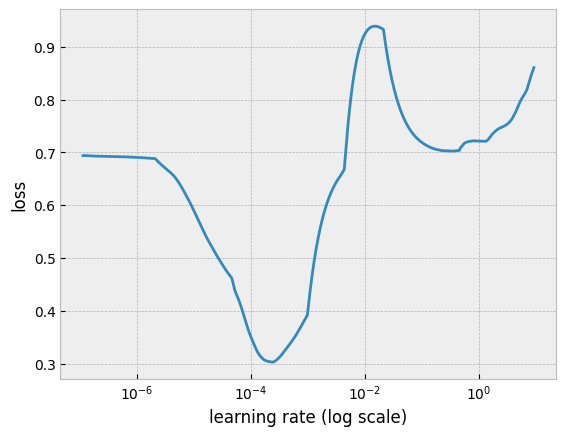

Enter learning rate: 1e-4


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
225/225 [==============================] - 75s 244ms/step - loss: 0.4025 - accuracy: 0.8358 - val_loss: 0.3064 - val_accuracy: 0.8725
Epoch 2/10
225/225 [==============================] - 49s 219ms/step - loss: 0.2126 - accuracy: 0.9239 - val_loss: 0.3815 - val_accuracy: 0.8600
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9642
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 6.666666666666667e-05 (if not early_stopping).
225/225 [==============================] - 49s 219ms/step - loss: 0.1199 - accuracy: 0.9642 - val_loss: 0.4849 - val_accuracy: 0.8700
Epoch 4/10
225/225 [==============================] - 49s 220ms/step - loss: 0.0663 - accuracy: 0.9844 - val_loss: 0.4970 - val_accuracy: 0.8550
Epoch 4: early stopping
Weights from best epoch have been loaded into model.
13/13 [==============================] - 4s 5

Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 512
done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/6
225/225 [==============================] - 140s 473ms/step - loss: 0.6172 - accuracy: 0.6653
Epoch 2/6
225/225 [==============================] - 106s 473ms/step - loss: 0.3205 - accuracy: 0.8706
Epoch 3/6
225/225 [==============================] - 106s 473ms/step - loss: 0.4632 - accuracy: 0.7636
Epoch 4/6
225/225 [==============================] - 106s 473ms/step - loss: 0.8658 - accuracy: 0.4953
Epoch 5/6
225/225 [==============================] - 21s 91ms/step - loss: 2.2741 - accuracy: 0.5014


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


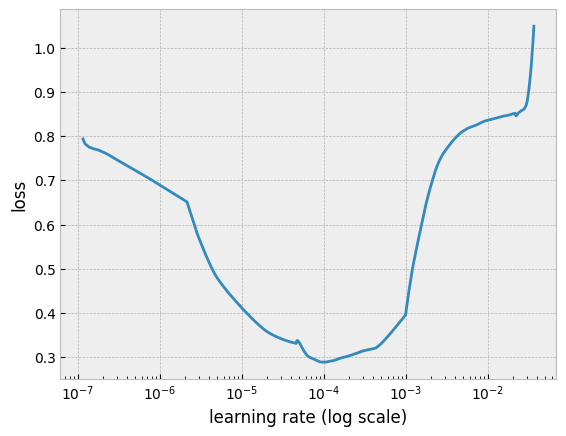

Enter learning rate: 5e-5


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/10
225/225 [==============================] - 133s 531ms/step - loss: 0.3697 - accuracy: 0.8317 - val_loss: 0.2459 - val_accuracy: 0.9025
Epoch 2/10
225/225 [==============================] - 111s 495ms/step - loss: 0.1663 - accuracy: 0.9442 - val_loss: 0.2642 - val_accuracy: 0.9000
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9733
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 3.3333333333333335e-05 (if not early_stopping).
225/225 [==============================] - 111s 495ms/step - loss: 0.0828 - accuracy: 0.9733 - val_loss: 0.3140 - val_accuracy: 0.9075
Epoch 4/10
225/225 [==============================] - 112s 496ms/step - loss: 0.0256 - accuracy: 0.9925 - val_loss: 0.4555 - val_accuracy: 0.9050
Epoch 4: early stopping
Weights from best epoch have been loaded into model.
13/13 [==============================] - 

done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/6
225/225 [==============================] - 182s 772ms/step - loss: 0.7022 - accuracy: 0.5050
Epoch 2/6
225/225 [==============================] - 173s 770ms/step - loss: 0.6913 - accuracy: 0.5411
Epoch 3/6
225/225 [==============================] - 172s 765ms/step - loss: 0.5913 - accuracy: 0.7092
Epoch 4/6
225/225 [==============================] - 174s 775ms/step - loss: 0.3595 - accuracy: 0.8483
Epoch 5/6
225/225 [==============================] - 173s 771ms/step - loss: nan - accuracy: 0.6261
Epoch 6/6
225/225 [==============================] - 174s 774ms/step - loss: nan - accuracy: 0.5050


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


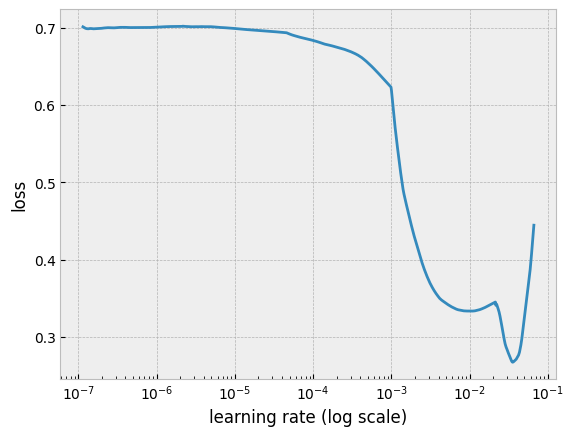

Enter learning rate: 2e-2


begin training using triangular learning rate policy with max lr of 0.02...
Epoch 1/10
225/225 [==============================] - 11s 38ms/step - loss: 0.4827 - accuracy: 0.7683 - val_loss: 0.3954 - val_accuracy: 0.8175
Epoch 2/10
225/225 [==============================] - 7s 33ms/step - loss: 0.1882 - accuracy: 0.9375 - val_loss: 0.6679 - val_accuracy: 0.8200
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9792
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.013333333333333332 (if not early_stopping).
225/225 [==============================] - 7s 33ms/step - loss: 0.0636 - accuracy: 0.9792 - val_loss: 0.8283 - val_accuracy: 0.7975
Epoch 4/10
225/225 [==============================] - 7s 33ms/step - loss: 0.0180 - accuracy: 0.9939 - val_loss: 0.9272 - val_accuracy: 0.8100
Epoch 4: early stopping
Weights from best epoch have been loaded into model.
13/13 [==============================] - 1s 14ms/step
 

In [ ]:
models = ['distilbert','bert', 'bigru']
histories_bal = {}
results_bal = {}

for model_name in models:
    print(f"Training and evaluating model: {model_name}")
    learner, train, val, preproc = prepare_and_lr_find(model_name, X_train, y_train, X_val, y_val)
    learner.lr_plot()
    best_lr = float(input("Enter learning rate: "))
    history, validation = train_and_save_predictor(model_name, learner, train, val, preproc, best_lr, class_weight_dict)
    results_bal[model_name] = validation
    histories_bal[model_name] = history

    del learner, train, val, preproc, history, validation
    clear_session()
    gc.collect()


### Evaluation

This section uses a balanced dataset, randomly sampling 2000 reviews each from target and non-target categories, totaling 4000 reviews. Train models Distilbert, Bert, and BiGRU. Since BiGRU is not a Transformer, preprocessing here used ktrain's text_from_array. Bert performs well, followed by Distilbert, and then the non-transformer BiGRU.




| Model    | Precision (0) | Recall (0) | F1-Score (0) | Support (0) | Precision (1) | Recall (1) | F1-Score (1) | Support (1) | Accuracy | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1-Score |
|----------|---------------|------------|--------------|-------------|---------------|------------|--------------|-------------|----------|----------------------|-------------------|---------------------|------------------------|---------------------|----------------------|
| distilbert | 0.86          | 0.86       | 0.86         | 182         | 0.88          | 0.89       | 0.88         | 218         | 0.87     | 0.87                 | 0.87              | 0.87                | 0.87                   | 0.87                | 0.87                 |
| bert     | 0.92          | 0.86       | 0.89         | 182         | 0.89          | 0.94       | 0.91         | 218         | 0.90     | 0.90                 | 0.90              | 0.90                | 0.90                   | 0.90                | 0.90                 |
| bigru    | 0.79          | 0.81       | 0.80         | 182         | 0.84          | 0.82       | 0.83         | 218         | 0.82     | 0.82                 | 0.82              | 0.82                | 0.82                   | 0.82                | 0.82                 |


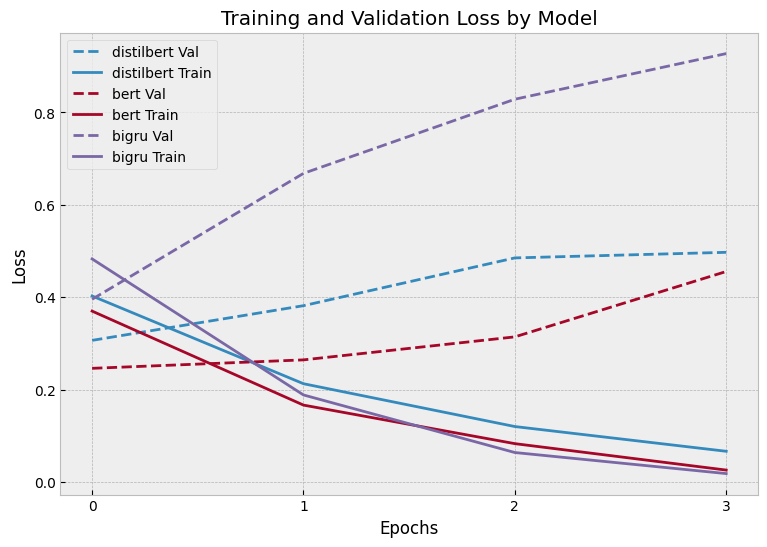

In [ ]:
plot_histories(histories_bal, key='loss')

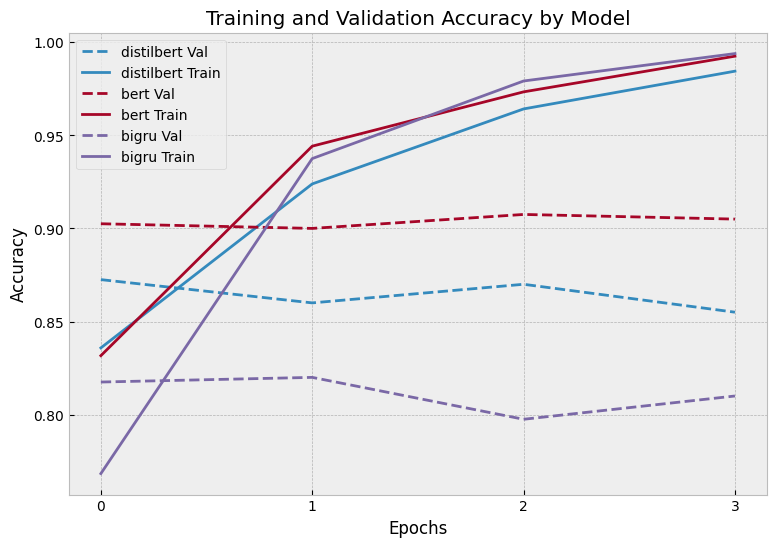

In [ ]:
plot_histories(histories_bal, key='accuracy')

Model: distilbert
[[156  26]
 [ 25 193]]


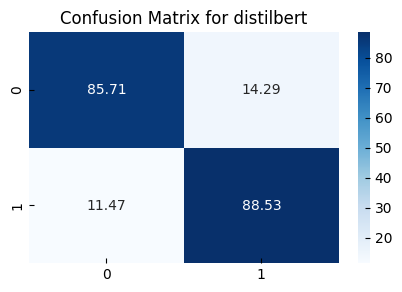


Model: bert
[[157  25]
 [ 14 204]]


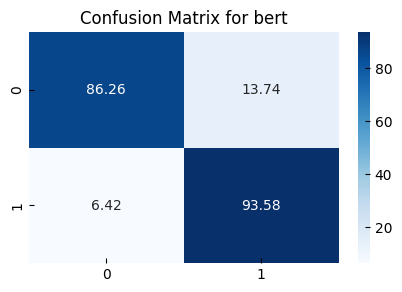


Model: bigru
[[148  34]
 [ 39 179]]


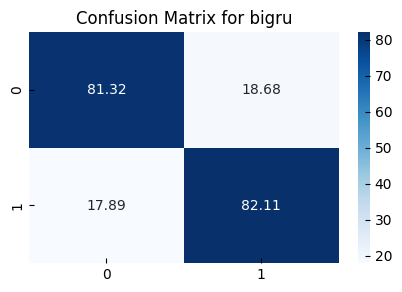

In [ ]:
print_results(results_bal)

Here it was observed that the correct classification was significantly more balanced between the two categories. Bert has the highest percentage of correct classification for the two categories. And its AUC value is 0.96, while BiGRU is 0.9.
However, the performance of Bert and Distilbert is not as good as when using the Transformer-specific preprocessing approach.

In [ ]:
y_preds = [get_model_predictions(model_name, X_val) for model_name in models]

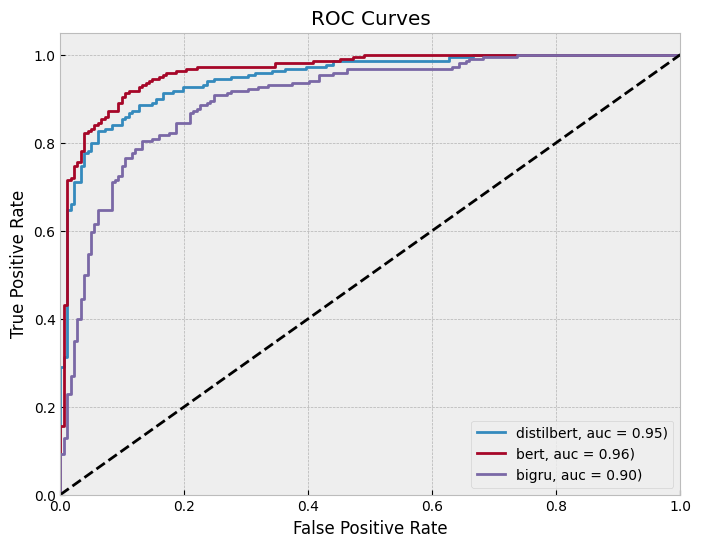

In [ ]:
plot_roc_curves(models, y_preds, y_val)

## Test

In [ ]:
!pip install -q https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

     \ 6.9 MB 17.7 MB/s 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

### predictor_roberta_base

Here test some reviews using Roberta-base trained model as a predictor. The first four texts are reviews related to 'healthy living' or 'wellness'. They are correctly classified as target positive, with a probability greater than 0.9, and display the contribution of each word to this prediction. The final two texts are non-target reviews, also correctly predicted as negative.

In [ ]:
predictor = ktrain.load_predictor("%s/predictor_roberta-base" % MODEL_DIR)

In [ ]:
for text in test_docs:
  print("---------------------------")
  print(text)
  pred = predictor.predict(text)
  print('The text is predicted to be', pred)
  explanation = predictor.explain(text)
  display(explanation)

---------------------------
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
The text is predicted to be positive


---------------------------
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
The text is predicted to be positive


---------------------------
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
The text is predicted to be positive


---------------------------
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
The text is predicted to be positive


---------------------------
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.
The text is predicted to be negative


---------------------------
A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.
The text is predicted to be negative


### predictor_bert

In [ ]:
predictor = ktrain.load_predictor("%s/predictor_bert" % MODEL_DIR)

In [ ]:
for text in test_docs:
  print("---------------------------")
  print(text)
  pred = predictor.predict(text)
  print('The text is predicted to be', pred)
  explanation = predictor.explain(text)
  display(explanation)

---------------------------
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
The text is predicted to be positive


---------------------------
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
The text is predicted to be positive


---------------------------
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
The text is predicted to be positive


---------------------------
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
The text is predicted to be positive


---------------------------
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.
The text is predicted to be negative


---------------------------
A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.
The text is predicted to be negative


notebook from [repo](https://github.com/elfchildRichter/dtsa5798_topic_detection_k_train)<br>